In [74]:
%matplotlib notebook

In [75]:
from random_network import *

In [281]:
from scipy.signal import butter, sosfiltfilt, sosfreqz

def butter_bandpass(band, fs, order, plot=False):
    nyq = 0.5 * fs
    normalized_band = np.divide(band, nyq)
    sos = butter(order, normalized_band, analog=False, btype='band', output='sos')
    if plot:
        plt.figure()
        w, h = sosfreqz(sos, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h))
        plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
        plt.title('Band: [%.1f, %.1f], Order: %i' % (min(band), max(band), order))
        plt.xlabel('Frequency (Hz)')
        plt.xlim(0., min(nyq, 2. * max(band)))
        plt.ylabel('Gain')
        plt.grid(True)
        plt.show()

    return sos

def butter_bandpass_filter(data, band, fs, order=15, plot=False):
    sos = butter_bandpass(band, fs, order=order, plot=plot)
    y = sosfiltfilt(sos, data, padtype=None)
    return y

In [317]:
dt = 1.  # ms
fs = 1000. / dt
duration = 4000.  # ms
target_mean_rate = 20. # Hz
# mod_freq = 70. # Hz
mod_freq = 7. # Hz
target_envelope = 5.  # Hz
# filter_band = [30., 100.]  # Hz
filter_band = [4., 10.]  # Hz

In [318]:
t = np.arange(0., duration, dt)

In [319]:
rate = target_mean_rate + target_envelope * np.cos(2. * np.pi * t * mod_freq / 1000.)

<IPython.core.display.Javascript object>


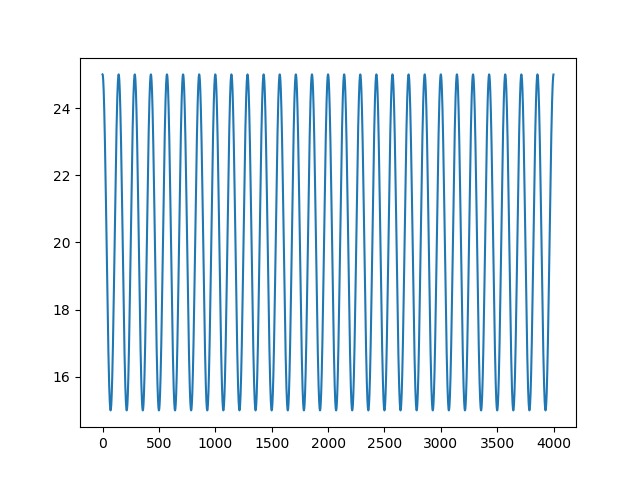

In [320]:
plt.figure()
plt.plot(t, rate)

In [321]:
pad_dur = 10. * 1000. / np.min(filter_band) # ms
print 'pad_dur: %.1f (ms)' % pad_dur
pad_len = int(pad_dur / dt)
padded_rate = mirror_signal(rate, pad_len)
padded_t = np.concatenate([-t[1:pad_len+1][::-1], t, np.add(t[:pad_len], len(t) * dt)])

pad_dur: 2500.0 (ms)


<IPython.core.display.Javascript object>


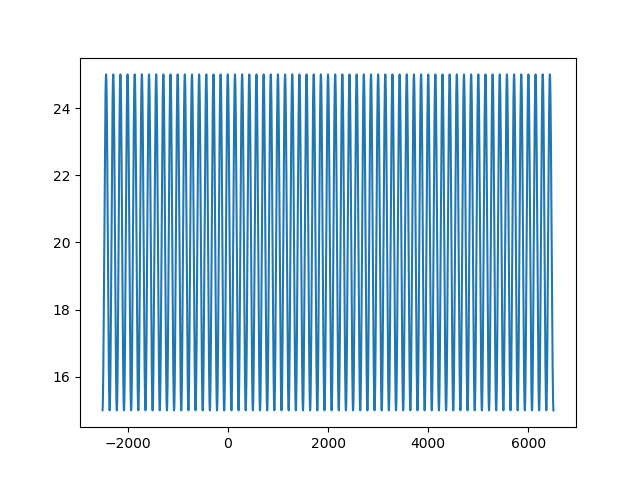

In [322]:
plt.figure()
plt.plot(padded_t, padded_rate)

<IPython.core.display.Javascript object>


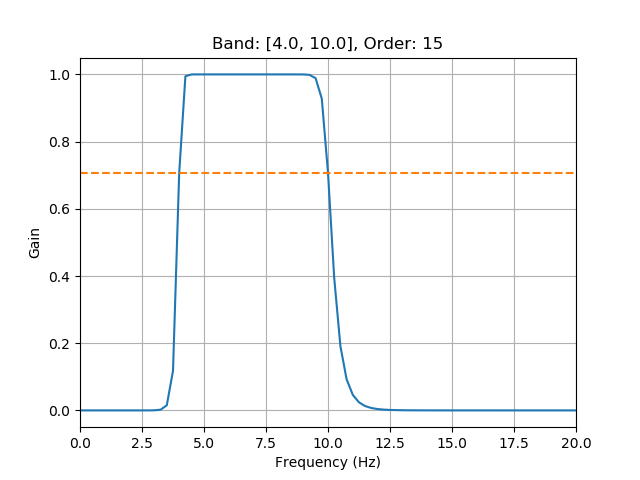

In [323]:
padded_filtered_rate = butter_bandpass_filter(padded_rate, filter_band, fs, plot=True)
filtered_rate = padded_filtered_rate[pad_len:-pad_len]

<IPython.core.display.Javascript object>


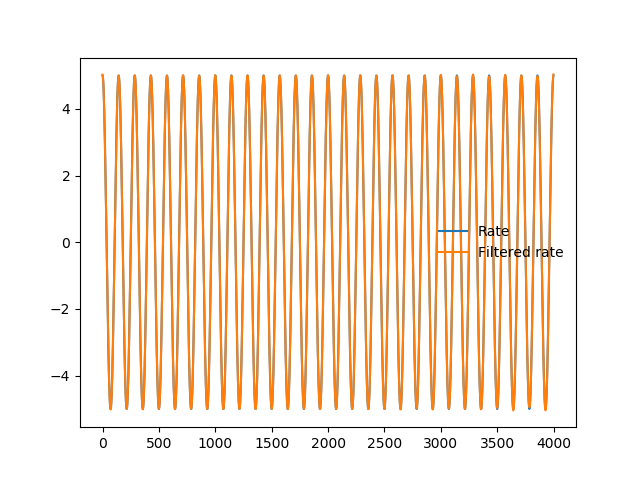

In [324]:
plt.figure()
plt.plot(t, np.subtract(rate, np.mean(rate)), label='Rate')
plt.plot(t, filtered_rate, label='Filtered rate')
plt.legend(loc='best', frameon=False, framealpha=0.5)
plt.show()

In [325]:
local_random = random.Random()
local_random.seed(0)

In [326]:
num_cells = 200
spike_trains = []
binned_spike_count = []
for i in xrange(num_cells):
    this_spike_train = get_inhom_poisson_spike_times_by_thinning(rate, t, dt=dt, generator=local_random)
    spike_trains.append(this_spike_train)
    this_binned_spike_count = np.zeros_like(t)
    indexes = []
    ti = 0
    for this_spike in this_spike_train:
        i = np.where(t[ti:] >= this_spike)[0]
        if np.any(i):
            indexes.append(i[0])
    this_binned_spike_count[indexes] = 1.
    binned_spike_count.append(this_binned_spike_count)
        

<IPython.core.display.Javascript object>


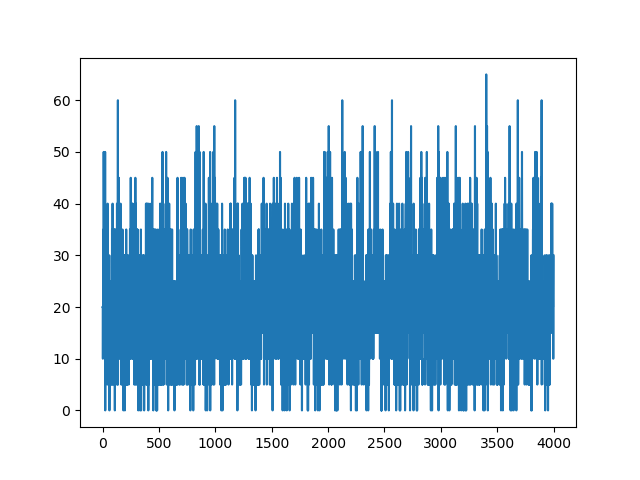

20.08


In [327]:
plt.figure()
mean_binned_spike_count = np.divide(np.mean(binned_spike_count, axis=0), dt/1000.)
plt.plot(t, mean_binned_spike_count)
print np.mean(mean_binned_spike_count)

In [328]:
pad_dur = 10. * 1000. / np.min(filter_band) # ms
print 'pad_dur: %.1f (ms)' % pad_dur
pad_len = int(pad_dur / dt)
padded_mean_binned_spike_count = mirror_signal(mean_binned_spike_count, pad_len)

pad_dur: 2500.0 (ms)


<IPython.core.display.Javascript object>


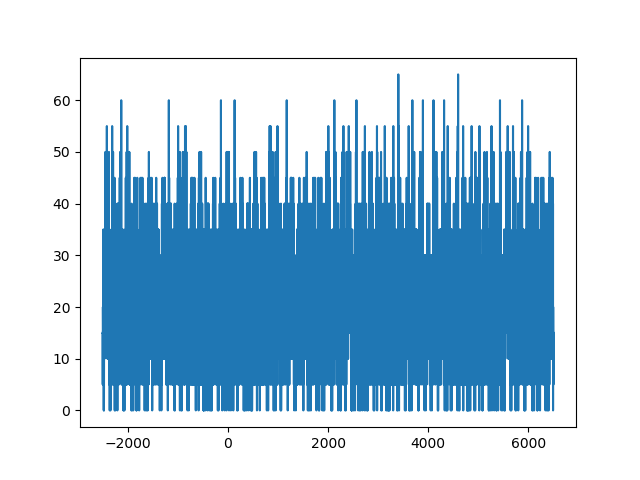

In [329]:
plt.figure()
plt.plot(padded_t, padded_mean_binned_spike_count)

<IPython.core.display.Javascript object>


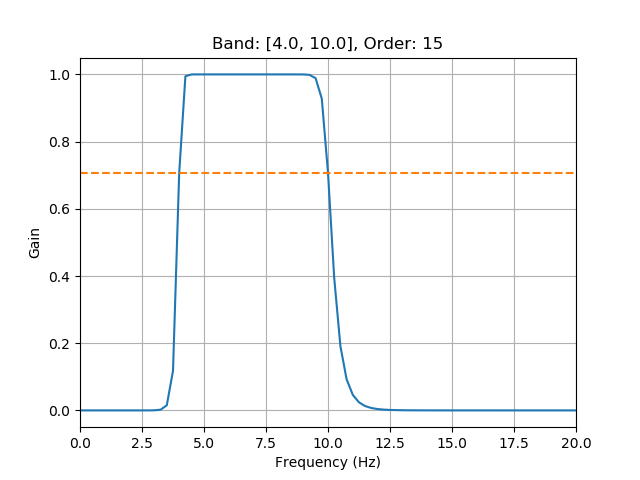

In [330]:
filtered_padded_mean_binned_spike_count = butter_bandpass_filter(padded_mean_binned_spike_count, filter_band, fs, plot=True)
filtered_mean_binned_spike_count = filtered_padded_mean_binned_spike_count[pad_len:-pad_len]

<IPython.core.display.Javascript object>


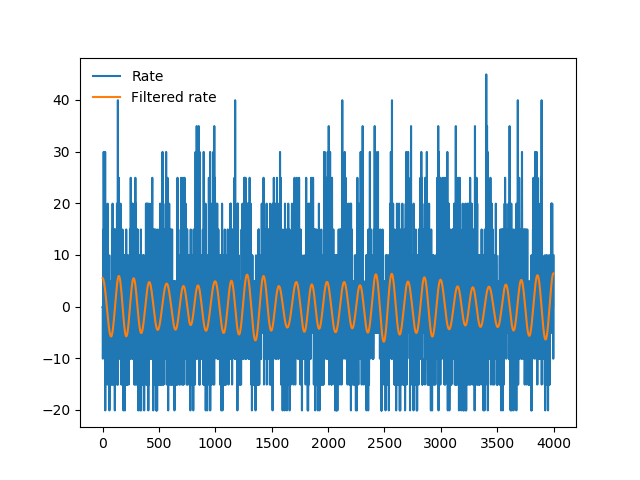

In [331]:
plt.figure()
plt.plot(t, np.subtract(mean_binned_spike_count, np.mean(mean_binned_spike_count)), label='Rate')
plt.plot(t, filtered_mean_binned_spike_count, label='Filtered rate')
plt.legend(loc='best', frameon=False, framealpha=0.5)
plt.show()

In [332]:
envelope = np.abs(scipy.signal.hilbert(filtered_mean_binned_spike_count))

<IPython.core.display.Javascript object>


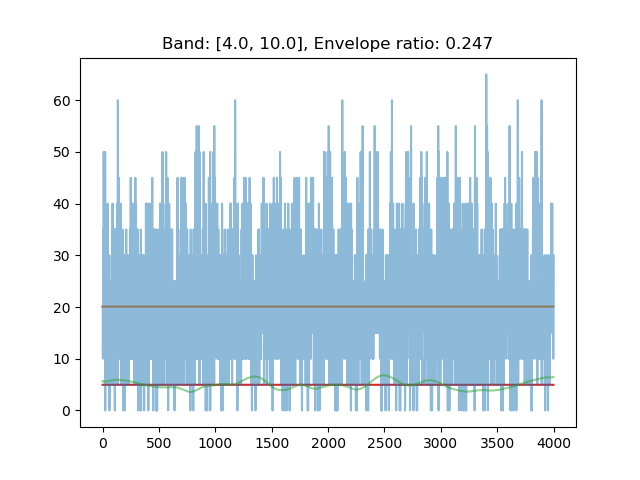

Envelope ratio: target: 0.250, actual: 0.247


In [333]:
mean_envelope = np.mean(envelope)
average_mean_rate = np.mean(mean_binned_spike_count)
envelope_ratio = mean_envelope / average_mean_rate
plt.figure()
plt.plot(t, mean_binned_spike_count, alpha=0.5, zorder=1)
plt.plot(t, np.ones_like(t) * average_mean_rate, zorder=0)
plt.plot(t, envelope, alpha=0.5, zorder=1)
plt.plot(t, np.ones_like(t) * mean_envelope, zorder=0)
plt.title('Band: [%.1f, %.1f], Envelope ratio: %.3f' % (min(filter_band), max(filter_band), envelope_ratio))
print('Envelope ratio: target: %.3f, actual: %.3f' % (target_envelope / target_mean_rate, envelope_ratio))